In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sundarannamalai_hair_diseases_path = kagglehub.dataset_download('sundarannamalai/hair-diseases')

print('Data source import complete.')


# Import

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


#Define path

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = r'../input/hair-diseases/Hair Diseases - Final/train'
test_path = r'../input/hair-diseases/Hair Diseases - Final/test'
val_path = r'../input/hair-diseases/Hair Diseases - Final/val'

# Create model

In [ ]:
#Load Pretrained VGG19 Model
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#Freezes all VGG19 layers so their weights are not updated during training.
for layer in vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
# Get the number of classes from the training directory
folders = glob(train_path + '/*')
num_classes = len(folders)
# Build custom classifier on top of VGG19
x = Flatten()(vgg19.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create model
model = Model(inputs=vgg19.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Load data

In [ ]:
# ImageDataGenerator is used to load, preprocess, and augment images.  scales pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
# Load images from folders
train_set = train_datagen.flow_from_directory(directory=train_path,
                                                target_size = (224,224),
                                                batch_size = 64,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)
val_set = val_datagen.flow_from_directory(directory=val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)

Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


# Compile model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [ ]:
history = model.fit(
                  train_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  steps_per_epoch=len(train_set),
                  validation_steps=len(test_set)
                )

Epoch 1/20
150/150 [==============================] - 257s 2s/step - loss: 1.3979 - accuracy: 0.5285 - val_loss: 0.6411 - val_accuracy: 0.8100
Epoch 2/20
150/150 [==============================] - 159s 1s/step - loss: 0.8222 - accuracy: 0.7305 - val_loss: 0.5004 - val_accuracy: 0.8492
Epoch 3/20
150/150 [==============================] - 160s 1s/step - loss: 0.5915 - accuracy: 0.8135 - val_loss: 0.3160 - val_accuracy: 0.9117
Epoch 4/20
150/150 [==============================] - 158s 1s/step - loss: 0.4699 - accuracy: 0.8575 - val_loss: 0.2244 - val_accuracy: 0.9508
Epoch 5/20
150/150 [==============================] - 158s 1s/step - loss: 0.4173 - accuracy: 0.8731 - val_loss: 0.2959 - val_accuracy: 0.9025
Epoch 6/20
150/150 [==============================] - 159s 1s/step - loss: 0.3868 - accuracy: 0.8803 - val_loss: 0.1824 - val_accuracy: 0.9442
Epoch 7/20
150/150 [==============================] - 158s 1s/step - loss: 0.3138 - accuracy: 0.9073 - val_loss: 0.1793 - val_accuracy: 0.9492

# Save model

In [ ]:
model.save("VGG19-Final.h5")
print("Model Saved as : VGG19-Final.h5")


Model Saved as : VGG19-Final.h5


#Evaluate

In [ ]:
evl = model.evaluate(test_set)

test_loss, test_acc = evl[0]*100, evl[1]*100


print(f'Test Accuracy = {test_acc} %')
print(f'Test Loss = {test_loss} %')

19/19 [==============================] - 17s 892ms/step - loss: 0.0564 - accuracy: 0.9900
Test Accuracy = 99.00000095367432 %
Test Loss = 5.635282024741173 %


#Plot

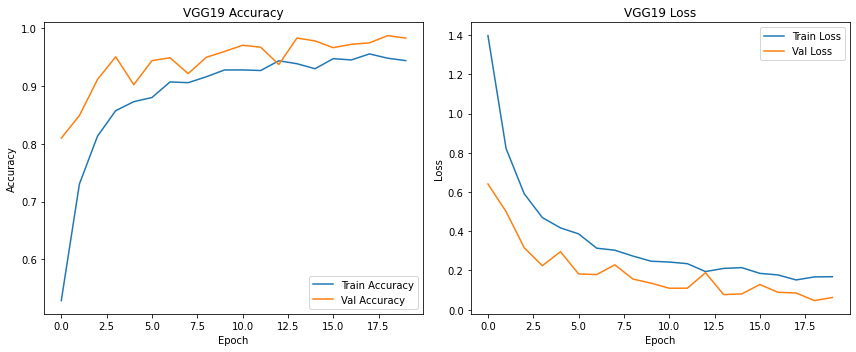

In [ ]:

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG19 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('VGG19 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


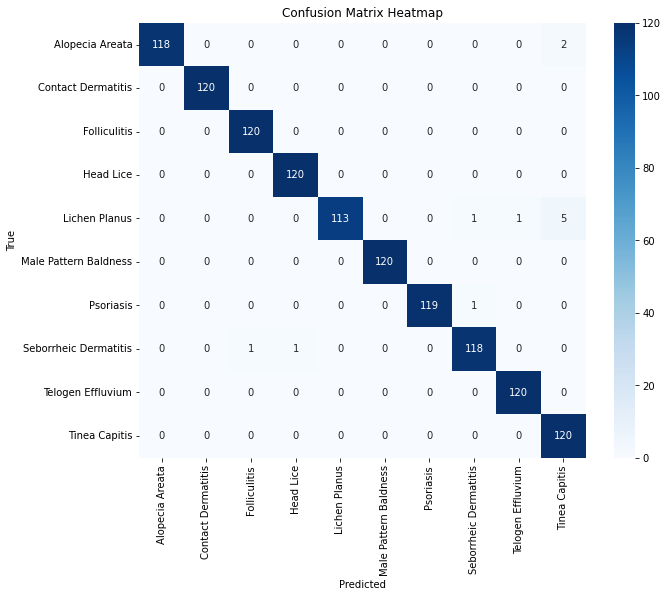

In [ ]:
# Get true labels and predicted labels
true_labels = test_set.classes
pred_probs = model.predict(test_set)
pred_labels = np.argmax(pred_probs, axis=1)

# Class names
class_names = list(test_set.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


Found 1200 images belonging to 10 classes.


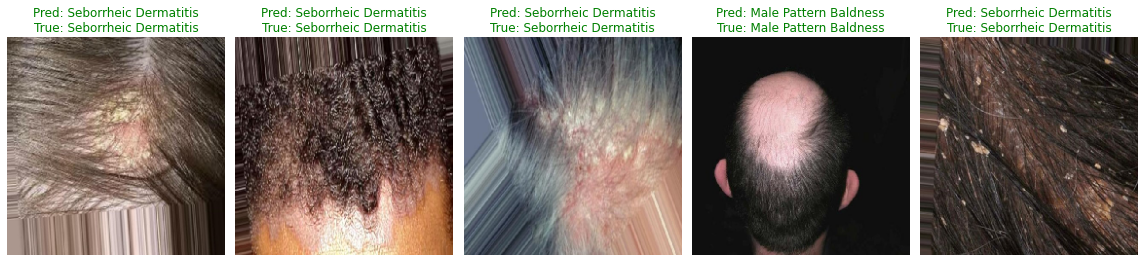

In [ ]:

# Get test images and true labels
x_test, y_true = next(test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1000,
    class_mode='categorical',
    shuffle=False))

# Predict with the model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Choose random indices to visualize
n = 5
indices = random.sample(range(len(x_test)), n)

# Plot images with predictions
plt.figure(figsize=(16, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, n, i + 1)
    plt.imshow(x_test[idx])
    plt.axis('off')
    true_label = class_names[y_true_labels[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.tight_layout()
plt.show()
